OneFormer
===

 * Paper: https://arxiv.org/abs/2211.06220

Supporting tasks:
 * Semantic segmentation
 * Instance segmentation
 * Panoptic segmentation

```bash
pip install torch torchvision
pip install transformers
pip install matplotlib
pip install supervision
```

In [1]:
import os
import numpy as np
from PIL import Image
import supervision as sv
import matplotlib.pyplot as plt
import torch
import torchvision
from transformers import OneFormerProcessor, OneFormerForUniversalSegmentation

device = "cuda" if torch.cuda.is_available() else "cpu"

processor = OneFormerProcessor.from_pretrained("shi-labs/oneformer_ade20k_swin_large")
model = OneFormerForUniversalSegmentation.from_pretrained("shi-labs/oneformer_ade20k_swin_large")


In [10]:
def inference(image, task_type, device="cpu"):
    assert task_type in ["semantic", "instance", "panoptic"]
    inputs = processor(
        images=image,
        task_inputs=[task_type],
        return_tensors="pt"
    )
    outputs = model(**inputs)
    # pass through image_processor for postprocessing
    if task_type == "semantic":
        prediction = processor.post_process_semantic_segmentation(
            outputs, target_sizes=[image.size[::-1]]
        )[0]
    elif task_type == "instance":
        prediction = processor.post_process_instance_segmentation(
            outputs, target_sizes=[image.size[::-1]]
        )[0]["segmentation"]
    elif task_type == "panoptic":
        prediction = processor.post_process_panoptic_segmentation(
            outputs, target_sizes=[image.size[::-1]
        ])[0]["segmentation"]

    return prediction

In [3]:
image_path = "../samples/fruits-01.jpg"

image = Image.open(image_path).convert("RGB")
image = image.resize((image.width // 4, image.height // 4))
print(image.size)

pred = inference(
    image, task_type="semantic", device=device
)

print("masks:", pred.shape, pred.unique())

(378, 504)


masks: torch.Size([504, 378]) tensor([ 15, 119])


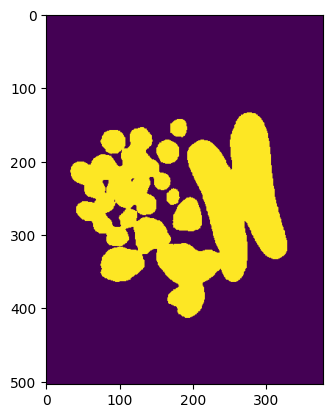

In [4]:
plt.imshow(pred.numpy())

In [5]:
def visualize_masks(image, mask):
    bboxes = torchvision.ops.masks_to_boxes(mask > 0)
    print("bboxes:", bboxes.shape)
    detections = sv.Detections(
        xyxy=bboxes.numpy(),
        mask=mask.numpy(),
        class_id=np.array([0] * len(bboxes)),
    )
    annotator = sv.MaskAnnotator()
    annotated_image = annotator.annotate(
        scene=image,
        detections=detections,
    )

    return annotated_image

In [6]:
np.unique(pred.numpy(), return_counts=True)

(array([ 15, 119]), array([148627,  41885]))

bboxes: torch.Size([1, 4])


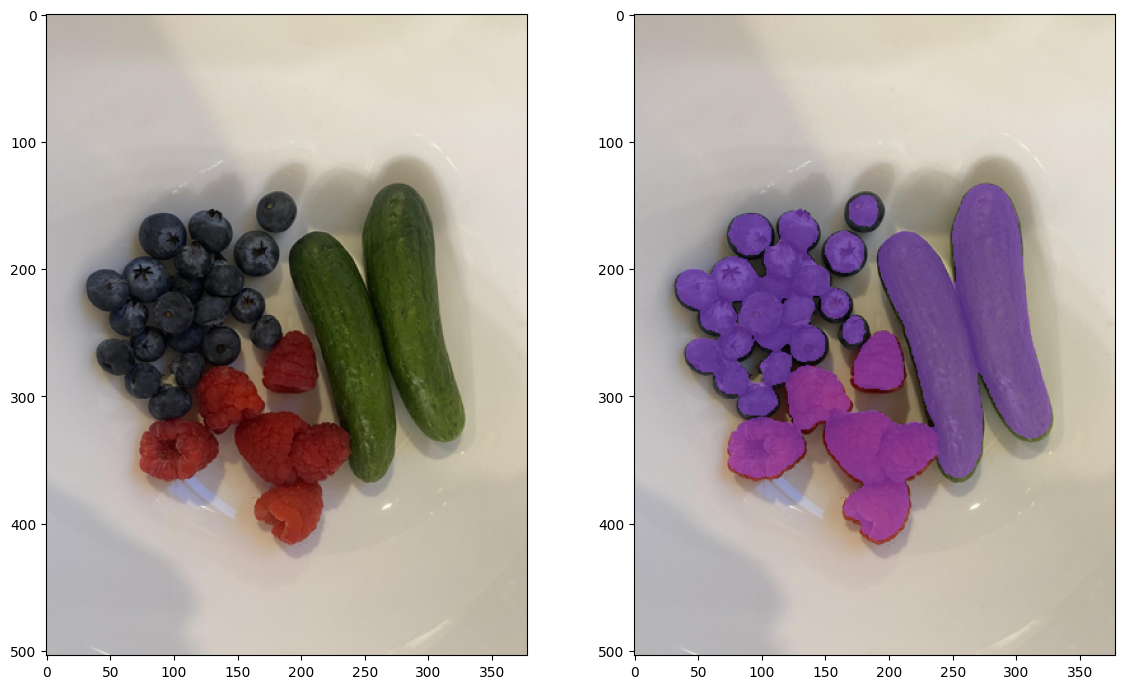

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 7))
axes[0].imshow(image.copy())
axes[1].imshow(visualize_masks(image.copy(), pred.unsqueeze(0) != 15))
plt.tight_layout()
plt.show()

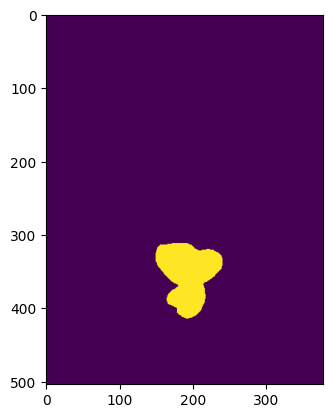

In [11]:
pred = inference(
    image, task_type="instance", device=device
)
plt.imshow(pred.numpy())

`label_ids_to_fuse` unset. No instance will be fused.


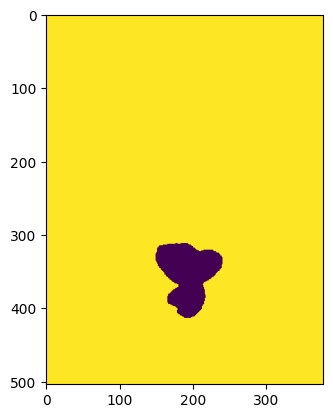

In [12]:
pred = inference(
    image, task_type="panoptic", device=device
)
plt.imshow(pred.numpy())